In [1]:
import numpy as np
from data_loader import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


import keras
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, Dense
from keras.models import Model
from keras.utils import plot_model, multi_gpu_model

Using TensorFlow backend.


In [2]:
data_file = "/datax/yzhang/training_data/training_data_chunk_0.pkl"
data = LoadModRecData(data_file, .9, .1, 0.)

test_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(test_file, 0.1, 0., 1.)



[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [3]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
number_of_samples_in_instance = data.instance_shape[1]
data.modTypes

array(['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB',
       'APSK16_c34', 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz',
       'FM_NB', 'FM_WB', 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK',
       'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16', 'QAM32', 'QAM64', 'QPSK'],
      dtype='<U11')

(1, 1024) 1750
(1, 1024) 257
(1, 1024) 798
(1, 1024) 363
(1, 1024) 652
(1, 1024) 43
(1, 1024) 1612
(1, 1024) 1737
(1, 1024) 1056
(1, 1024) 118
(1, 1024) 1227
(1, 1024) 1826
(1, 1024) 223
(1, 1024) 204
(1, 1024) 1968
(1, 1024) 1323
(1, 1024) 1833
(1, 1024) 1816
(1, 1024) 635
(1, 1024) 1181
(1, 1024) 747


/home/morads/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(1, 1024) 1529
(1, 1024) 1141
(1, 1024) 408


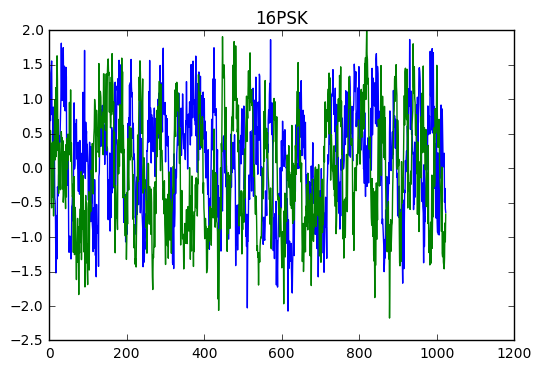

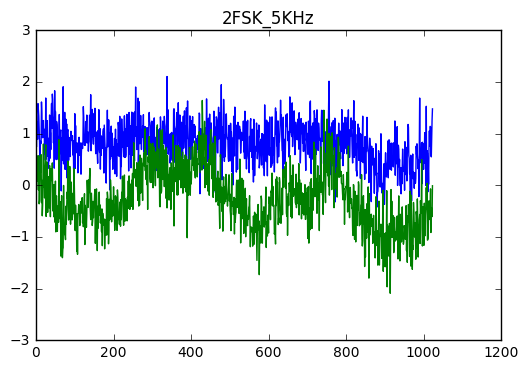

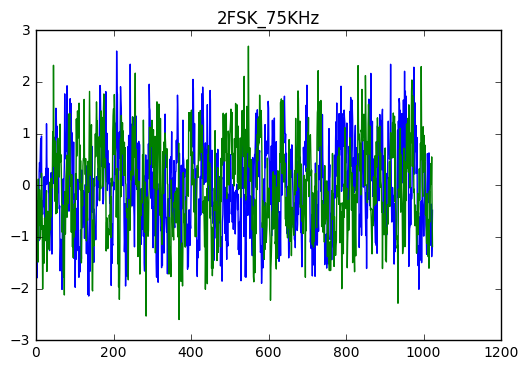

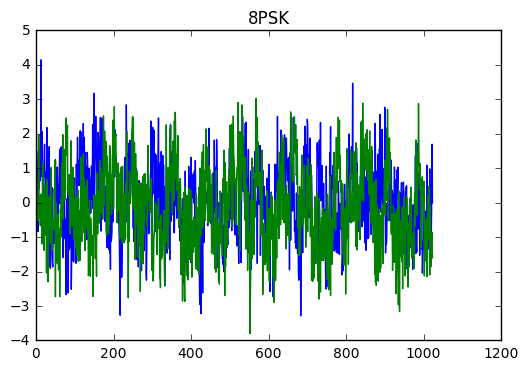

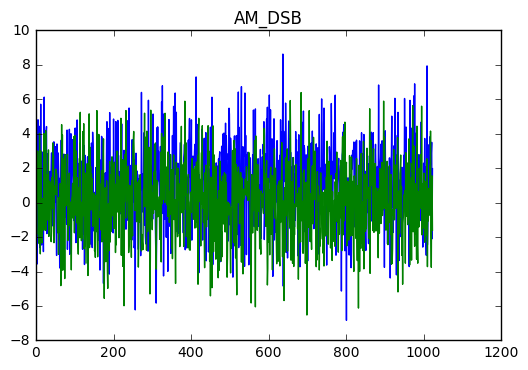

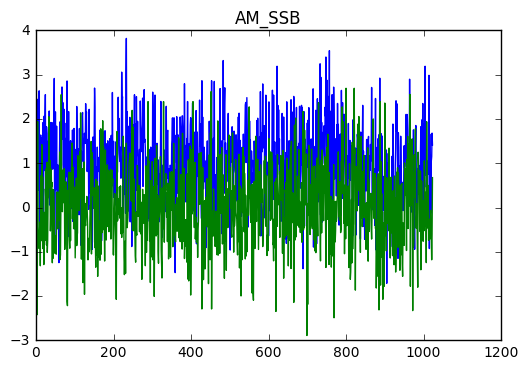

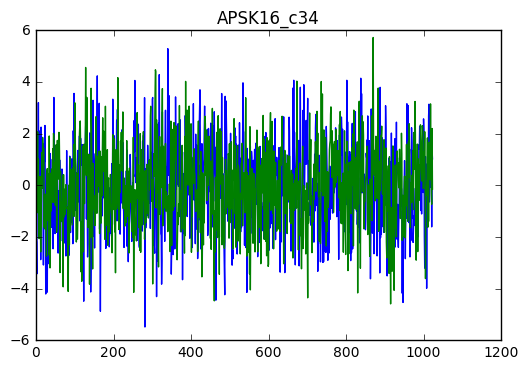

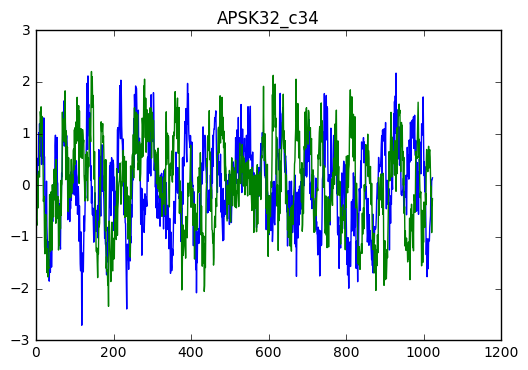

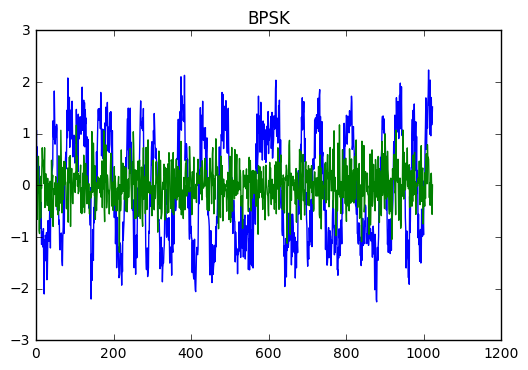

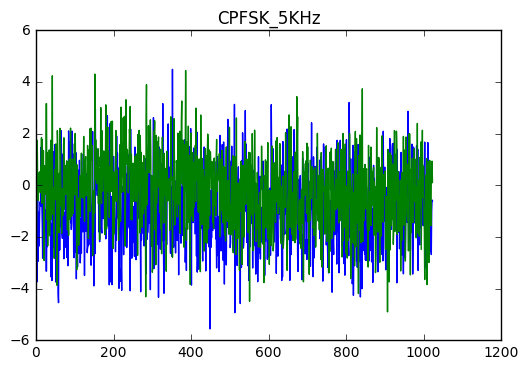

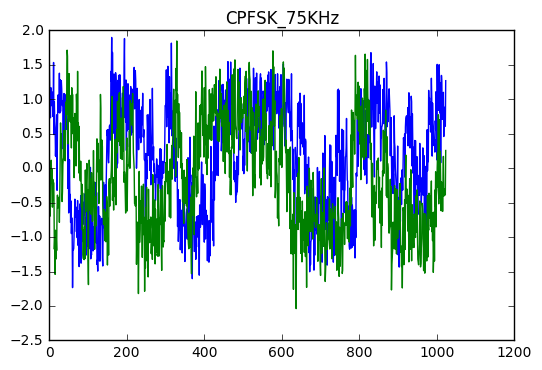

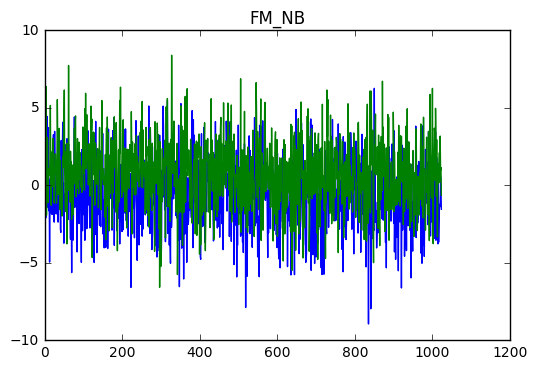

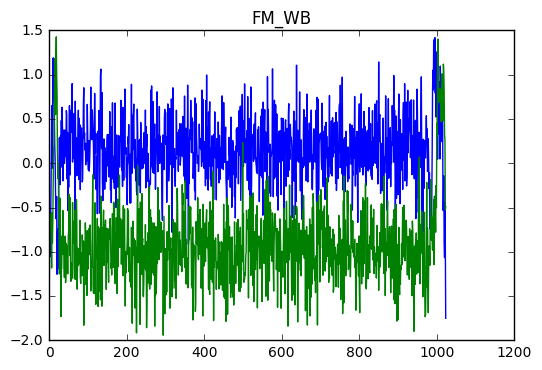

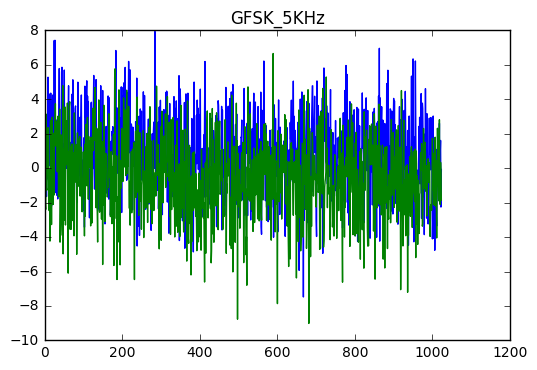

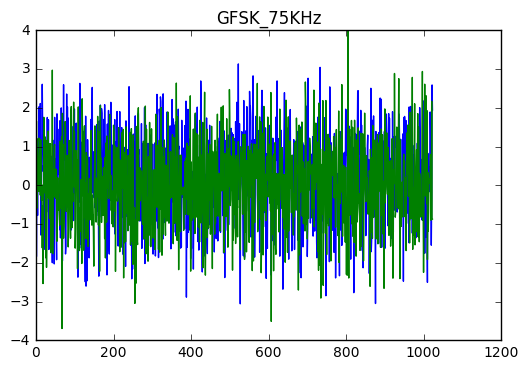

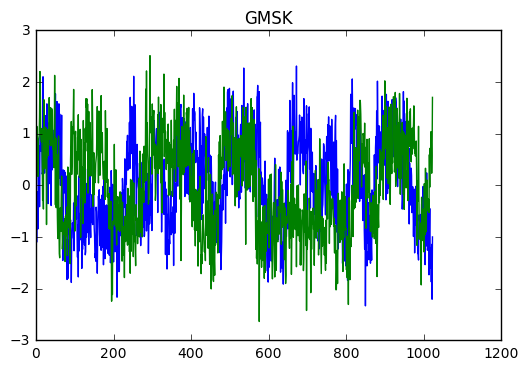

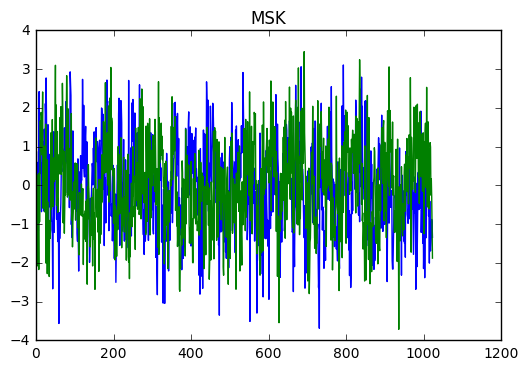

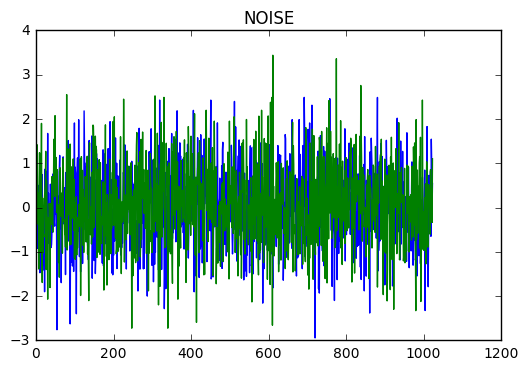

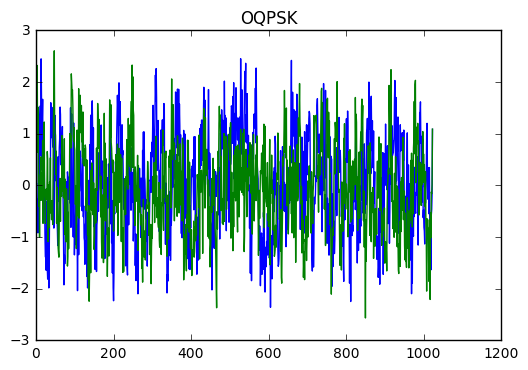

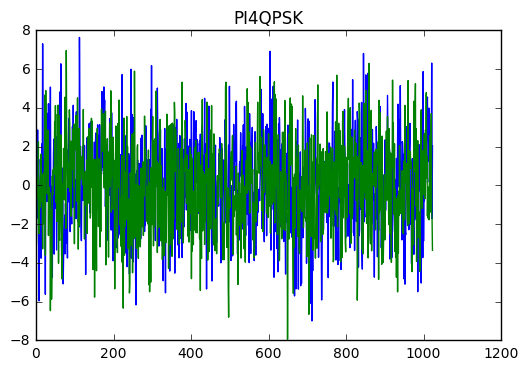

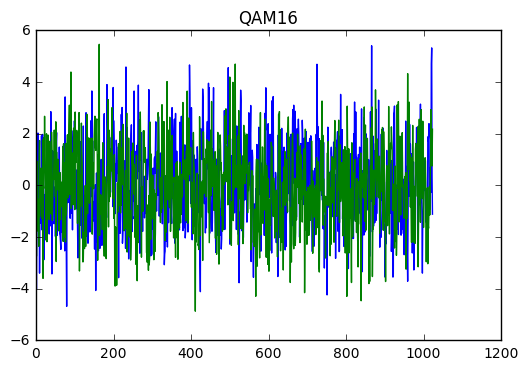

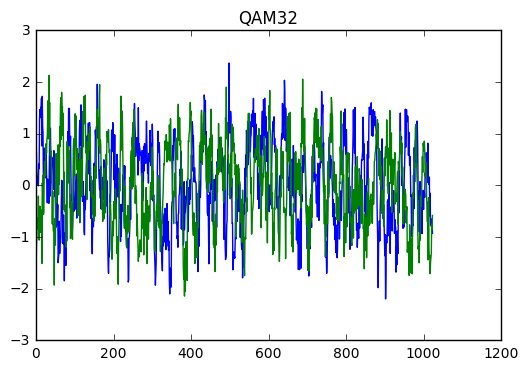

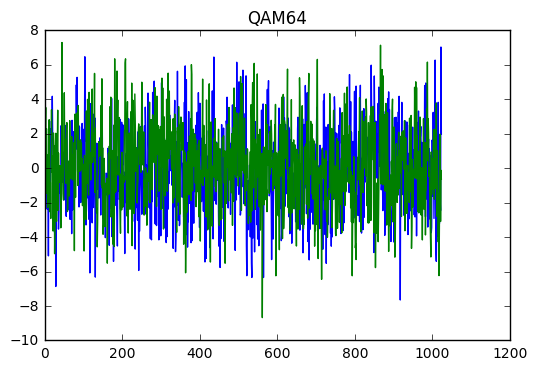

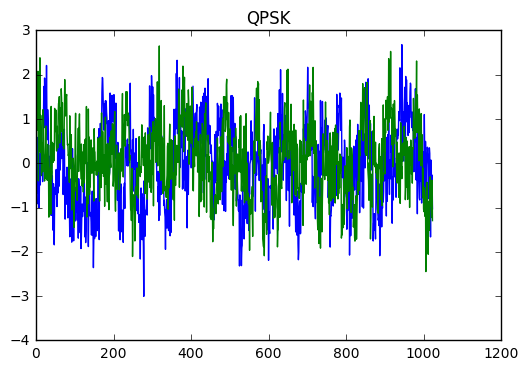

In [16]:
# for each modulation type, inspect some instances of data
for modType in data.modTypes[:]:
    min_SNR = -10
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    print(cdata.shape,index)

    # setup inspect
    sample_rate = number_of_samples_in_instance
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    
    plt.figure()
    plt.title(modType)
    plt.plot(cdata.squeeze().real)
    plt.plot(cdata.squeeze().imag)
    # inspect signal
plt.show()    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

In [44]:
def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv1D(fs[0], 1, padding='same', activation='relu')(input_img)
    tower_1 = Conv1D(fs[1], 3, padding='same', activation='relu')(tower_1)
    tower_2 = Conv1D(fs[2], 1, padding='same', activation='relu')(input_img)
    tower_2 = Conv1D(fs[3], 5, padding='same', activation='relu')(tower_2)
    tower_4 = MaxPooling1D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv1D(fs[4], 1, padding='same', activation='relu')(tower_4)
    output = keras.layers.concatenate([tower_1, tower_2, tower_4], axis = 2)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_first'):
#     num_layers = [2,4,10,4]
    num_layers = [1,1,1,1]
    x = Conv1D(64, 7, strides=2, data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv1D(192, 3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x, fs=[32,64,32,64,64])
#     x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(24, activation='softmax')(output)
    return out

input_img = Input(shape=(2,1024))
out = googleNet(input_img,data_format='channels_first')
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
conv1d_568 (Conv1D)             (None, 64, 512)      960         input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_153 (MaxPooling1D (None, 32, 512)      0           conv1d_568[0][0]                 
__________________________________________________________________________________________________
conv1d_569 (Conv1D)             (None, 32, 192)      295104      max_pooling1d_153[0][0]          
__________________________________________________________________________________________________
max_poolin

In [70]:
def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(filters=fs[1], kernel_size=1, padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=3, padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=5, padding='same', activation='relu')(tower_3)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same', activation='relu')(tower_4)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last'):
#     num_layers = [2,4,10,4]
    num_layers = [1,1,1,1]
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 64, kernel_size=[2,7], strides=[2,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192, kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
    x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x, fs=[32,64,32,64,64])
#     x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(24, activation='softmax')(output)
    return out

in_shp = (2, 1024)
input_img = Input(shape=in_shp)
out = googleNet(input_img,data_format='channels_last')
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
reshape_21 (Reshape)            (None, 2, 1024, 1)   0           input_34[0][0]                   
__________________________________________________________________________________________________
conv2d_485 (Conv2D)             (None, 1, 512, 64)   960         reshape_21[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_149 (MaxPooling2D (None, 1, 256, 64)   0           conv2d_485[0][0]                 
__________________________________________________________________________________________________
conv2d_486

In [48]:
plot_model(model, to_file='model.png', show_shapes = True)


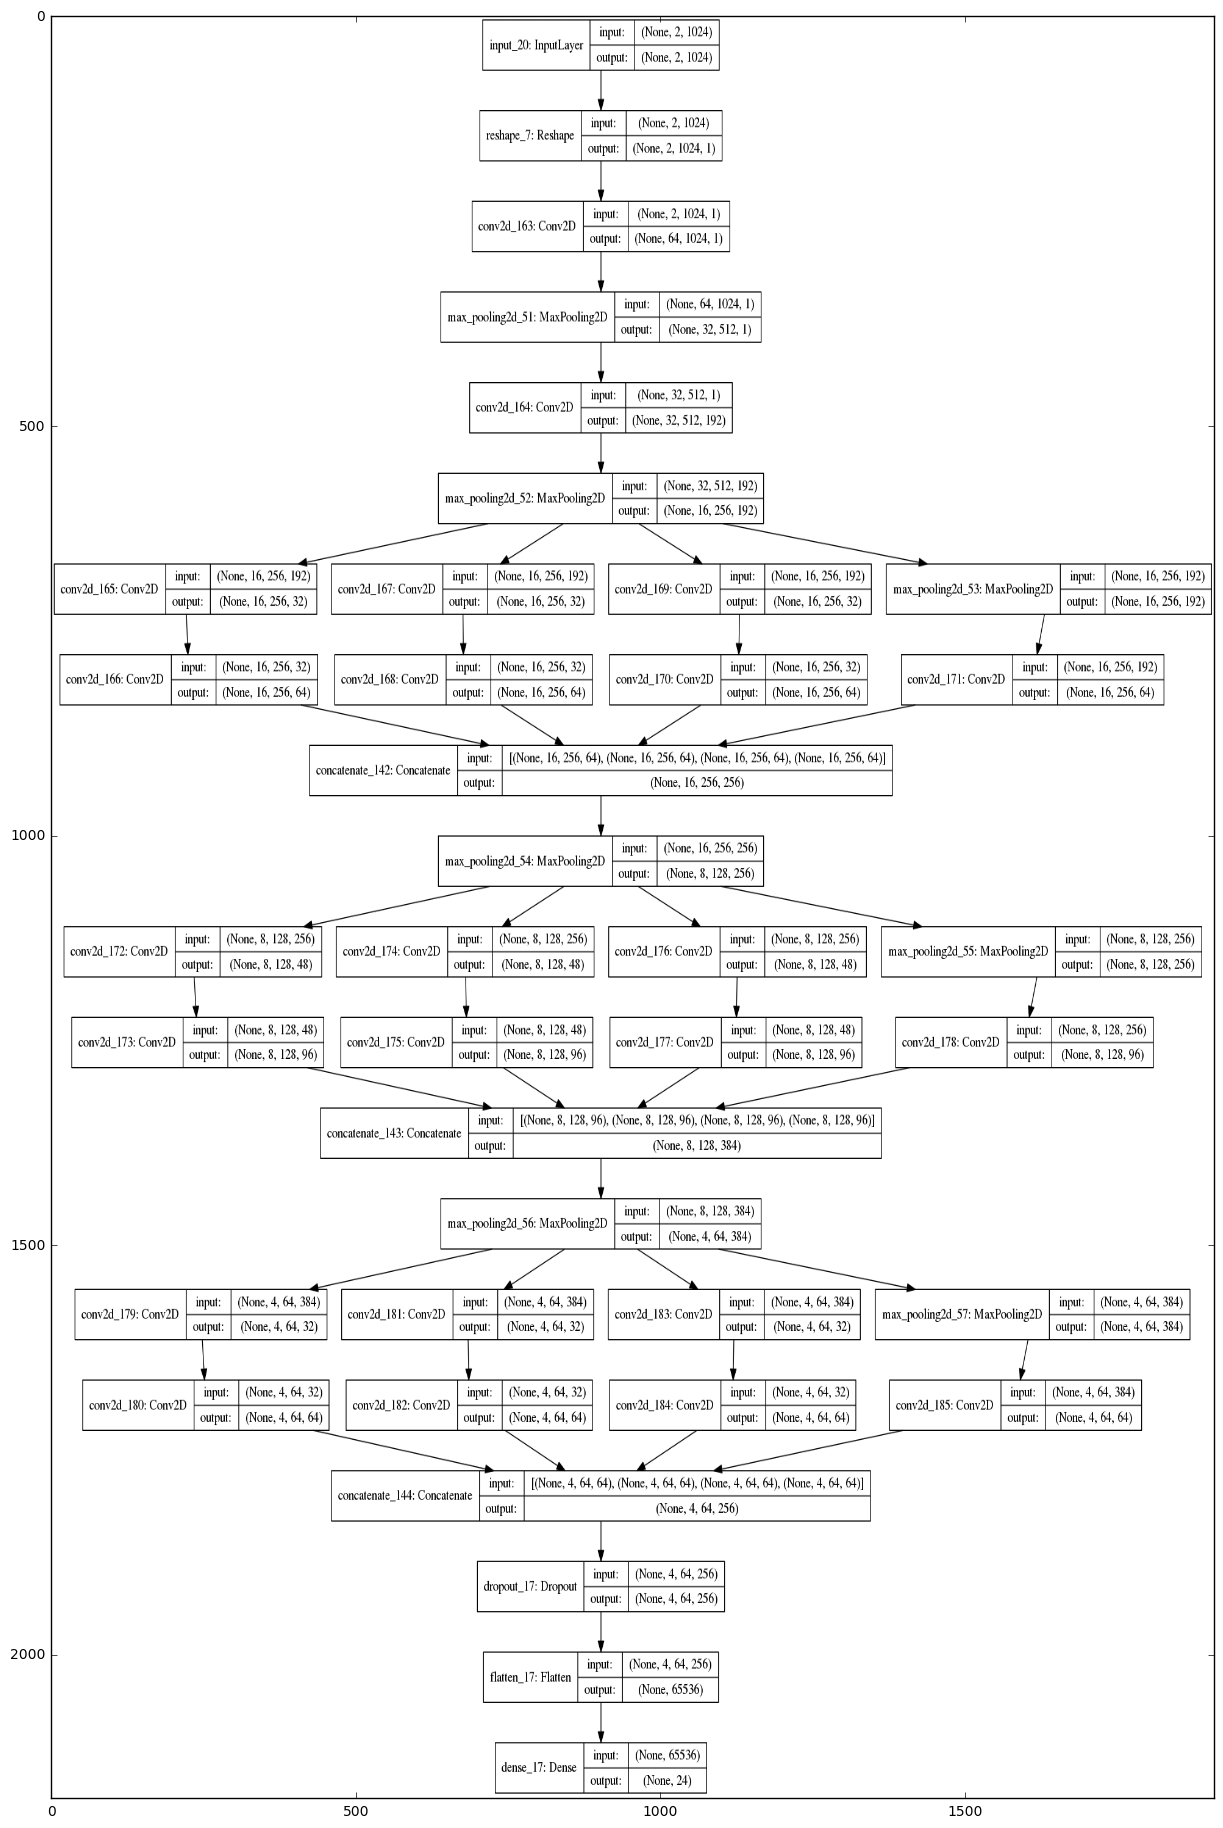

In [55]:
# Uncomment to visualize architecture

figure(figsize = (15,23))
img = mpimg.imread('model.png')
plt.imshow(img, aspect='auto')
plt.show()

In [71]:
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')
filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'
train_batch_size, number_of_epochs = 256, 40
tsteps = data.train_idx.size//train_batch_size
vsteps = data.val_idx.size//train_batch_size
train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)
# model.load_weights(filepath)
history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
     callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss'    , verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5    , verbose=0, mode='auto')
     ]) 
model.save('mod_classifier17.h5')  



print("Done")

/home/morads/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/morads/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=40, validation_data=<generator..., steps_per_epoch=1012, callbacks=[<keras.ca..., validation_steps=112, verbose=2)`


Epoch 1/40
 - 37s - loss: 1.5545 - val_loss: 1.2282
Epoch 2/40
 - 27s - loss: 1.1583 - val_loss: 1.0928
Epoch 3/40
 - 27s - loss: 1.0524 - val_loss: 1.0281
Epoch 4/40
 - 27s - loss: 0.9867 - val_loss: 0.9545
Epoch 5/40
 - 28s - loss: 0.9379 - val_loss: 0.9230
Epoch 6/40
 - 28s - loss: 0.8988 - val_loss: 0.8936
Epoch 7/40
 - 27s - loss: 0.8640 - val_loss: 0.9446
Epoch 8/40
 - 27s - loss: 0.8371 - val_loss: 0.8887
Epoch 9/40
 - 28s - loss: 0.8165 - val_loss: 0.8619
Epoch 10/40
 - 27s - loss: 0.7919 - val_loss: 0.8732
Epoch 11/40
 - 28s - loss: 0.7753 - val_loss: 0.8724
Epoch 12/40
 - 27s - loss: 0.7554 - val_loss: 0.8562
Epoch 13/40
 - 27s - loss: 0.7408 - val_loss: 0.8536
Epoch 14/40
 - 28s - loss: 0.7251 - val_loss: 0.8636
Epoch 15/40
 - 27s - loss: 0.7152 - val_loss: 0.8475
Epoch 16/40
 - 27s - loss: 0.7027 - val_loss: 0.8571
Epoch 17/40
 - 27s - loss: 0.6880 - val_loss: 0.8508
Epoch 18/40
 - 28s - loss: 0.6794 - val_loss: 0.8870
Epoch 19/40
 - 27s - loss: 0.6713 - val_loss: 0.8646
Ep

classes  ['16PSK' '2FSK_5KHz' '2FSK_75KHz' '8PSK' 'AM_DSB' 'AM_SSB' 'APSK16_c34'
 'APSK32_c34' 'BPSK' 'CPFSK_5KHz' 'CPFSK_75KHz' 'FM_NB' 'FM_WB'
 'GFSK_5KHz' 'GFSK_75KHz' 'GMSK' 'MSK' 'NOISE' 'OQPSK' 'PI4QPSK' 'QAM16'
 'QAM32' 'QAM64' 'QPSK']
SNR -15 Overall Accuracy:  0.2988965740590807 Out of 43229
SNR -10 Overall Accuracy:  0.3752199074074074 Out of 86400
SNR -5 Overall Accuracy:  0.6421206293301203 Out of 43157
SNR 0 Overall Accuracy:  0.7178134185007753 Out of 43209
SNR 5 Overall Accuracy:  0.785859731124326 Out of 86434
SNR 10 Overall Accuracy:  0.8106789381185829 Out of 43244


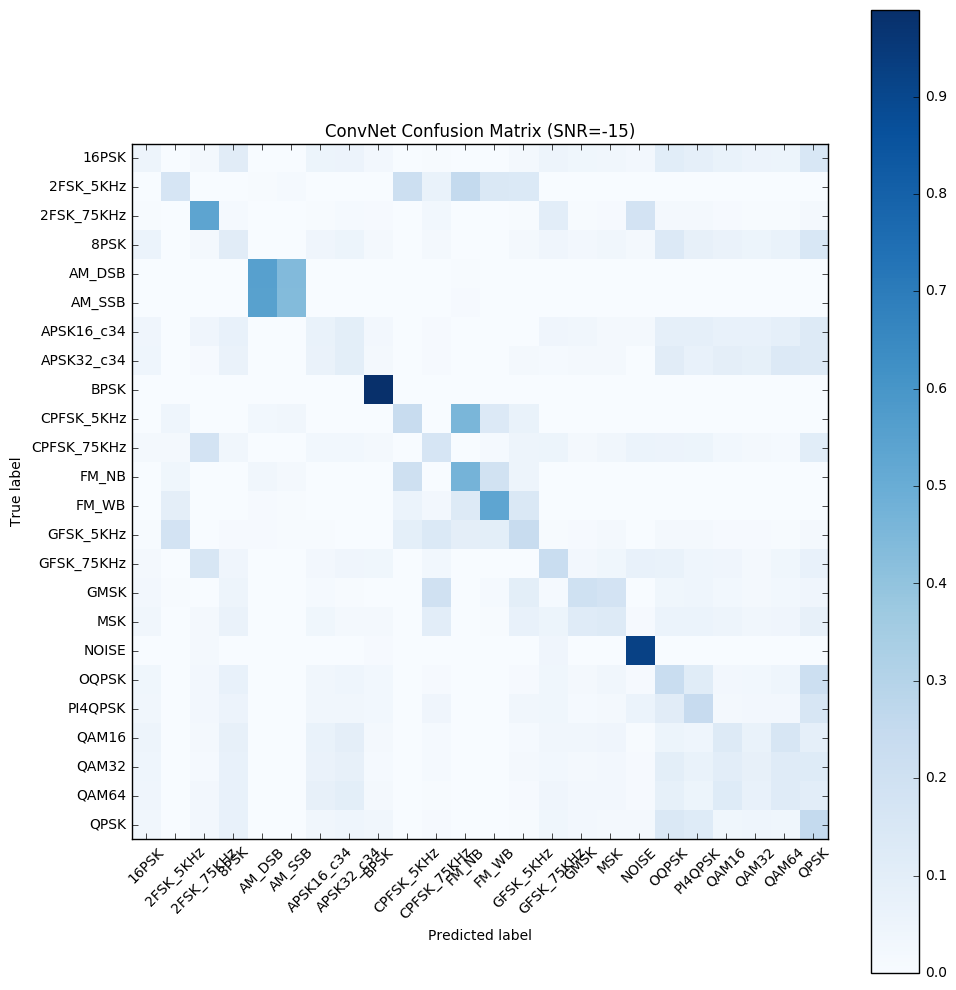

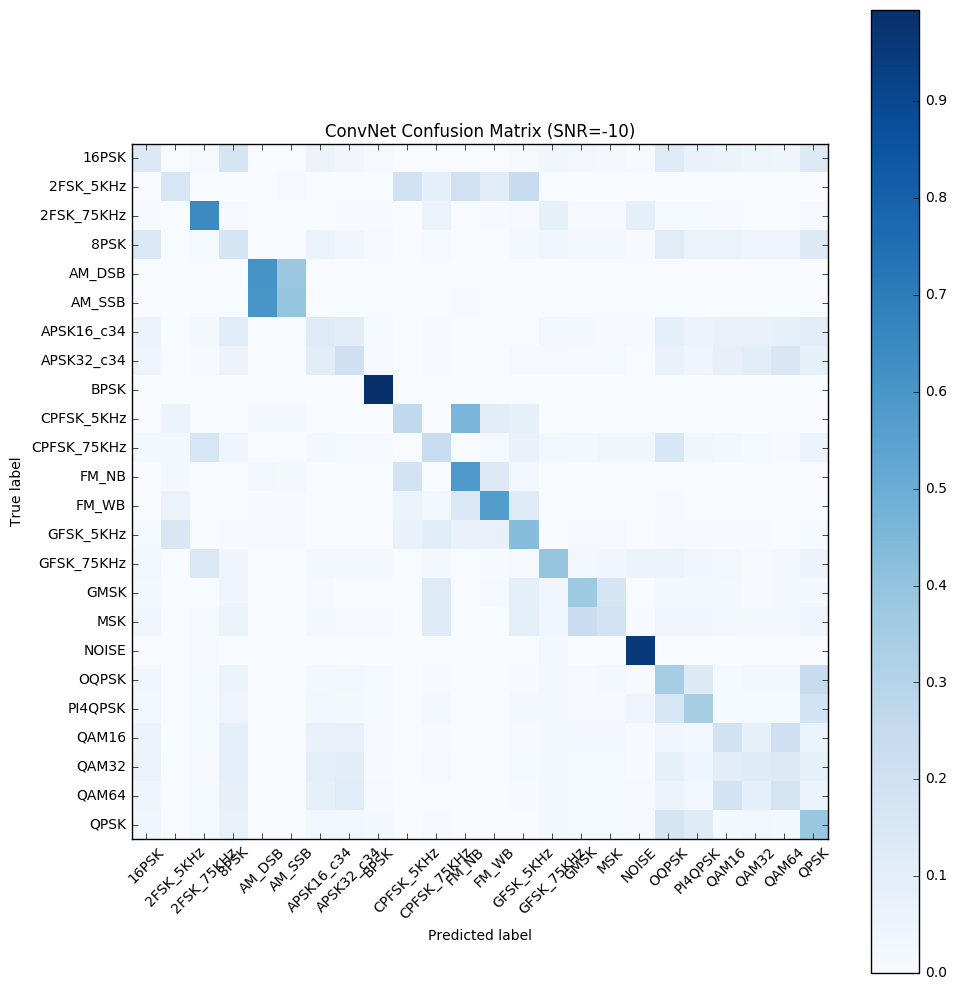

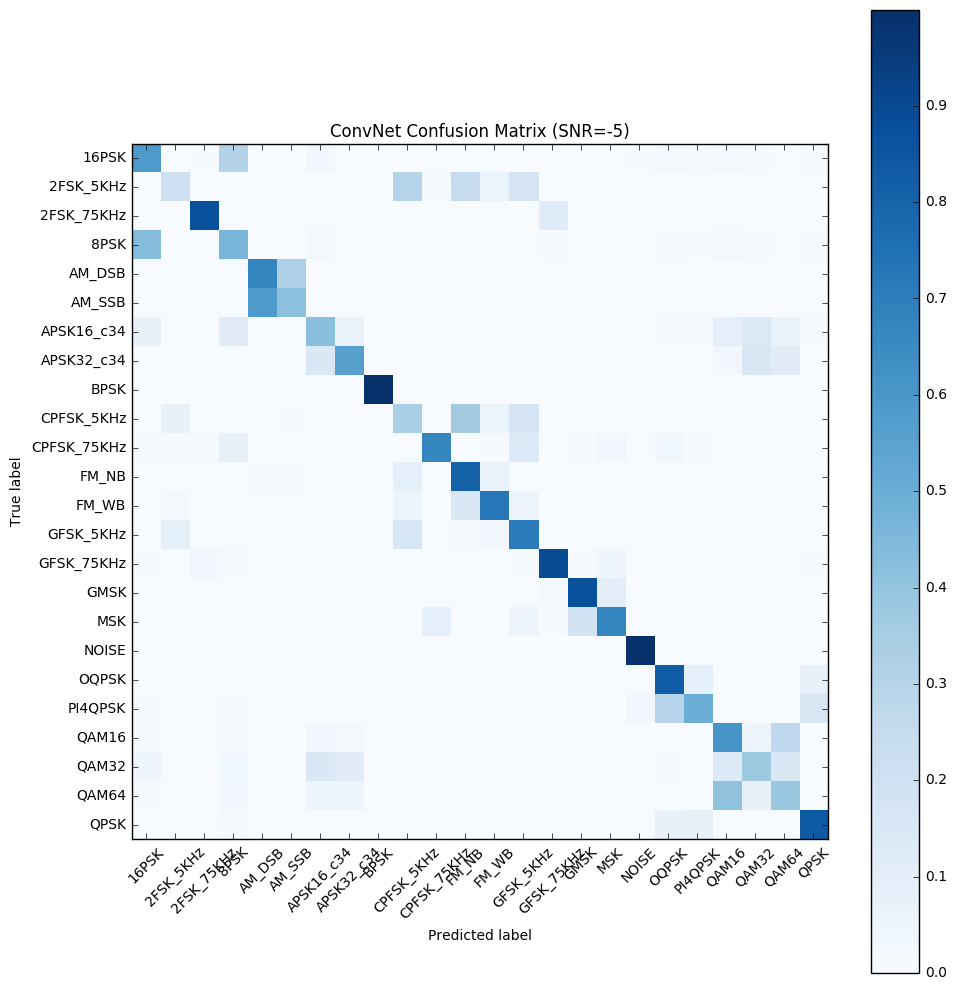

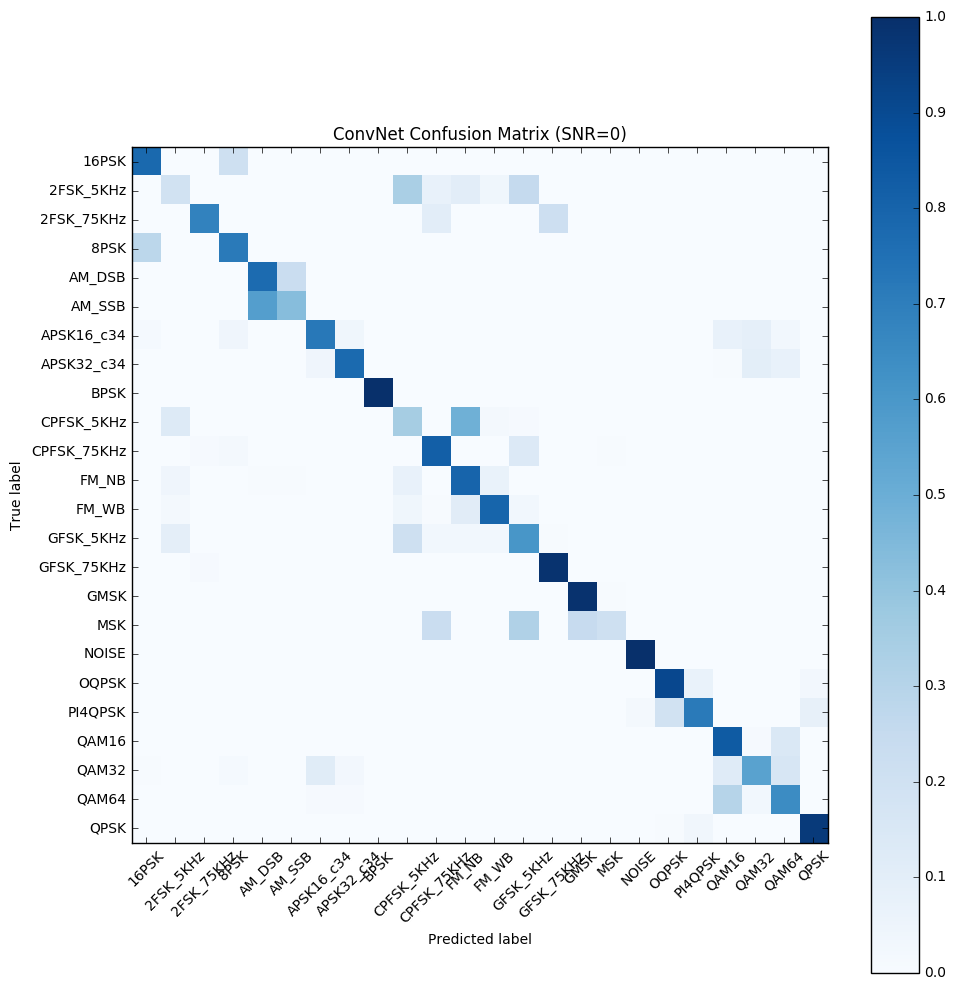

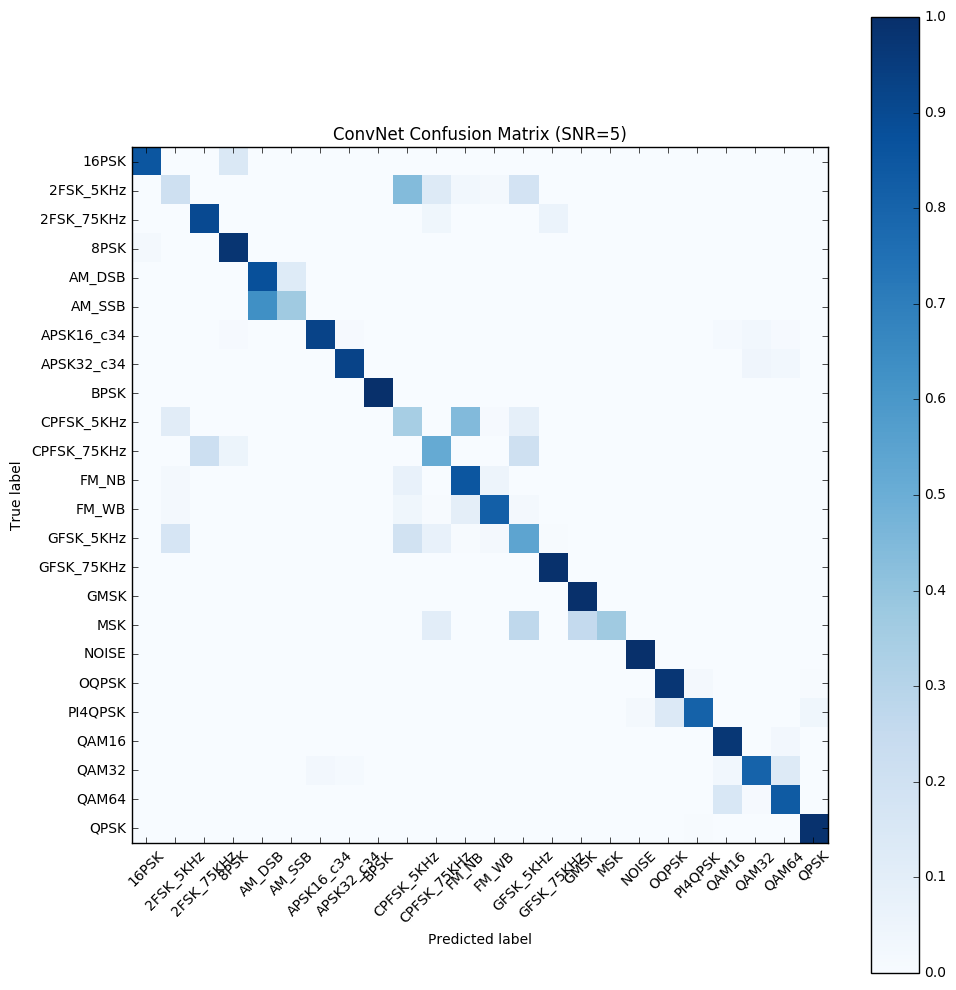

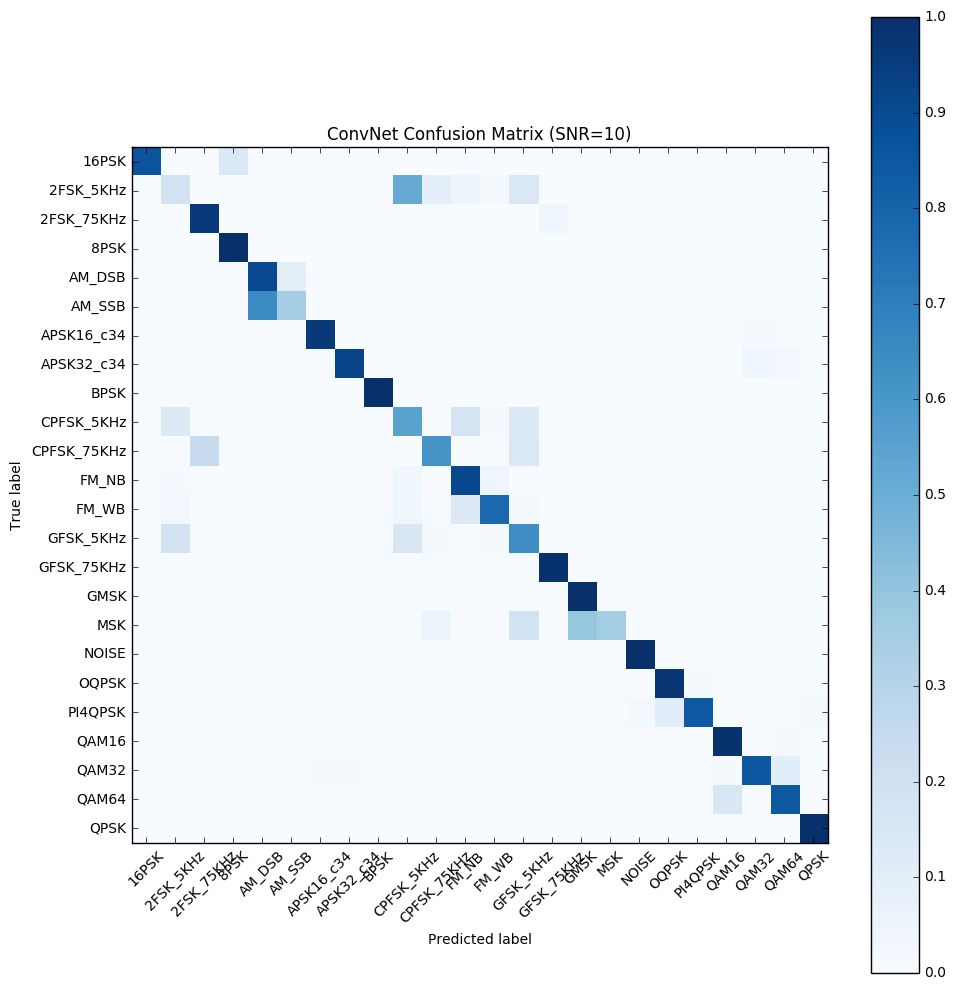

In [72]:
# Plot confusion matrix
acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)
for snr in snrs:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.test_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)